# Test basic framework functionality

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [54]:
import numpy as np
import pandas as pd
import xarray as xr

import geostats as gs

In [4]:
# read 5-degree monthly data and subset to US for faster testing
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly.nc")

ds = ds.where((-125 < ds.lon) & (ds.lon < -70) 
              & (25 < ds.lat) & (ds.lat < 50), drop=True)

ds

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 11, time: 71)
Coordinates:
  * lon      (lon) float64 -122.5 -117.5 -112.5 -107.5 ... -82.5 -77.5 -72.5
  * lat      (lat) float64 27.5 32.5 37.5 42.5 47.5
  * time     (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-07-01
Data variables:
    sif      (lon, lat, time) float32 nan nan nan ... 0.49874693 0.60988253
    xco2     (lon, lat, time) float32 nan nan nan ... 412.90573 409.11713

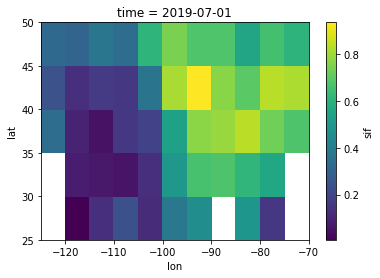

In [5]:
ds.sif.sel(time="2019-07-01").T.plot()

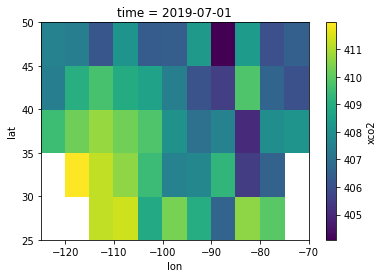

In [6]:
ds.xco2.sel(time="2019-07-01").T.plot()

In [29]:
Z1 = gs.Field(ds.xco2, "2019-07-01")
Z2 = gs.Field(ds.sif, "2019-07-01")

In [44]:
k1 = gs.Matern(sigma=1.5, nu=2.5, len_scale=500, nugget=0.25)
k2 = gs.Matern(sigma=1.5, nu=2.5, len_scale=500, nugget=0.25)
model = gs.BivariateMatern(k1, k2, rho=0.8, len_scale_b=500)
cokrige = gs.Cokrige(Z1, Z2, model, fast_dist=True)

In [51]:
pred_loc = Z1.coords
pred, pred_err = cokrige(pred_loc)

In [52]:
pred

array([158.0112987 , 156.79978339, 156.94233864, 159.24608177,
       158.2775257 , 157.64521977, 156.84731107, 158.85246841,
       158.82426127, 158.53683124, 158.02076728, 156.18829053,
       158.99973036, 158.48987487, 158.33377462, 157.57613192,
       157.26983509, 157.53296545, 157.88205907, 158.09432185,
       157.54887415, 156.4103398 , 158.51880123, 157.00950283,
       157.30876498, 157.13477598, 156.52223272, 157.78973501,
       157.21758872, 156.86530013, 156.45803918, 157.56871468,
       156.31616044, 158.05729816, 157.2039115 , 156.05310502,
       155.19066512, 158.72878094, 155.93599014, 155.80955015,
       158.37480352, 157.50936494, 158.14568185, 156.50754117,
       157.3476532 , 156.68413562, 156.24352405, 157.46508339,
       156.35131435, 156.48109293])

In [53]:
pred_err

array([0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03811419, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727,
       0.03268727, 0.03268727, 0.03268727, 0.03268727, 0.03268727])

In [70]:
ds_pred = pd.DataFrame({"lat": Z1.coords[:,0], "lon": Z1.coords[:,1], "pred": pred}).set_index(["lon", "lat"]).to_xarray()
ds_pred["pred_err"] = pd.DataFrame({"lat": Z1.coords[:,0], "lon": Z1.coords[:,1], "pred_err": pred_err}).set_index(["lon", "lat"]).to_xarray().pred_err

ds_pred

<xarray.Dataset>
Dimensions:   (lat: 5, lon: 11)
Coordinates:
  * lon       (lon) float64 -122.5 -117.5 -112.5 -107.5 ... -82.5 -77.5 -72.5
  * lat       (lat) float64 27.5 32.5 37.5 42.5 47.5
Data variables:
    pred      (lon, lat) float64 nan nan 158.0 156.8 ... nan 157.5 156.4 156.5
    pred_err  (lon, lat) float64 nan nan 0.03269 ... 0.03269 0.03269 0.03269

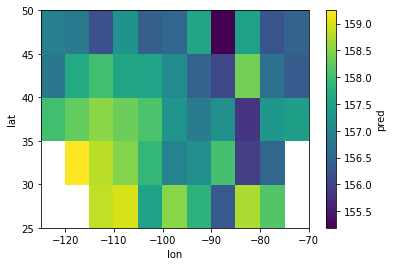

In [72]:
ds_pred.pred.T.plot()

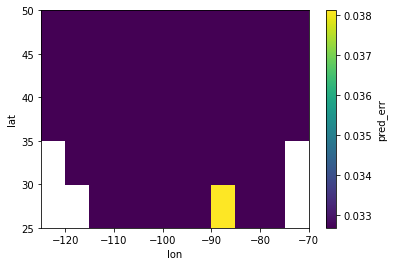

In [73]:
ds_pred.pred_err.T.plot()